### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [3]:
from ewatercycle.forcing import sources
from ewatercycle.models import HBVLocal
# from ewatercycle_DA.local_models.HBV import HBVLocal
from ewatercycle_DA import DA

In [4]:
# pip install ewatercycle-HBV --upgrade

#### set up paths

In [5]:
path = Path.cwd()
observations_path = path / "Observations"
output_path = path / "Output"
forcing_path = path / "Forcing"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"
for path_i in list(paths) + [figure_path]:
    path_i.mkdir(exist_ok=True)

#### Set up experiment info

In [6]:
experiment_start_date = "1999-03-01T00:00:00Z"
experiment_end_date = "2003-03-01T00:00:00Z"

HRU_id_int = 14138900
HRU_id = f'{HRU_id_int}'
if len(HRU_id) < 8: 
    HRU_id = '0' + HRU_id
    
alpha = 1.26
assimilate_window = 3 # after how many time steps to run the assimilate steps
n_particles = 100

sigma_p = 7.5 # perturbations added
sigma_w = 2  # weights for resampling

model_name = "HBVLocal"

save = False

### Create forcing

In [7]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

In [8]:
def H_states(Z):
    """Operator function extracts observable state from the state vector - only for states"""
    len_Z = 6
    if len(Z) == len_Z:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be {len_Z} but is {len(Z)}")

In [9]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

optimal_params = np.array([1.49951831e+00, 9.90966649e-01, 6.07668342e+02, 2.35735083e+00, 
                           2.32138963e-01, 1.00000000e+00, 9.92565842e-02, 1.95198919e-03,
                           4.81838625e+00])
final_storage = np.array([1.55784662, 222.25765439,  20.46978911,  28.59647711, 0.        ])

In [10]:
ensemble = DA.Ensemble(N=n_particles)

In [11]:
def experiment_run(ensemble, n_particles, optimal_params, s_0, model_name, camels_forcing, 
                   paths, HRU_id, sigma_p, sigma_w, H, assimilate_window, save):

    forcing_path, output_path, observations_path = paths
    # set up ensemble
    
    ensemble.setup()
    
    
    # values wihch you 
    setup_kwargs_lst = []
    for index in range(n_particles):
        setup_kwargs_lst.append({'parameters':','.join([str(p) for p in optimal_params]), 
                                'initial_storage':','.join([str(s) for s in s_0]),
                                 })
    
    
    # not required as of ewatercycle-HBV==1.8.2
    # ensemble.loaded_models.update({'HBVLocal': HBVLocal})
    
    # this initializes the models for all ensemble members. 
    ensemble.initialize(model_name=[model_name]*n_particles,
                        forcing=[camels_forcing]*n_particles,
                        setup_kwargs=setup_kwargs_lst) 
    
    # create a reference model
    ref_model = ensemble.ensemble_list[0].model
    ds = xr.open_dataset(forcing_path / ref_model.forcing.pr)
    
    
    # load observations
    observations = observations_path / f'{HRU_id}_streamflow_qc.txt'
    cubic_ft_to_cubic_m = 0.0283168466 
    
    new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
    new_header_dict = dict(list(zip(range(len(new_header)),new_header)))
    df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
    df_Q = df_Q.rename(columns=new_header_dict)
    df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
    df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
    df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
    df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
    df_Q.index.name = "time"
    df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
    df_Q = df_Q.dropna(axis=0)
    
    ds_obs_dir = observations_path / f'{HRU_id}_streamflow_qc.nc'
    ds_obs = xr.Dataset(data_vars=df_Q[['Q']])
    if not ds_obs_dir.exists():
        ds_obs.to_netcdf(ds_obs_dir)
    
    # set up hyperparameters
    lst_like_sigma = [sigma_p,sigma_p,sigma_p/1,sigma_p,sigma_p] + [0]
    hyper_parameters = {'like_sigma_weights' : sigma_w,
                        'like_sigma_state_vector' : lst_like_sigma,
                       }
    
    ensemble.initialize_da_method(ensemble_method_name = "PF", 
                                  hyper_parameters=hyper_parameters,                           
                                  state_vector_variables = stor_names + ["Q"], # the next three are keyword arguments but are needed. 
                                  observation_path = ds_obs_dir,
                                  observed_variable_name = "Q",
                                  measurement_operator = H, 
                               
                                )
    # extract units for later
    state_vector_variables = ensemble.ensemble_list[0].variable_names
    units = {}
    for var in state_vector_variables:
        units.update({var : ref_model.bmi.get_var_units(var)})
        
    ## run!
    n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
    time = []
    lst_state_vector = []
    lst_Q = [] 
    for i in tqdm(range(n_timesteps)):    
        time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
        # update every 3 steps 
        if i % assimilate_window == 0: 
            assimilate = True 
        else:
            assimilate = False
        ensemble.update(assimilate=assimilate)
         
        lst_state_vector.append(ensemble.get_state_vector())
        lst_Q.append(ensemble.get_value("Q").flatten())
    
    ensemble.finalize()
    
    # post process
    Q_m_arr = np.array(lst_Q).T
    state_vector_arr = np.array(lst_state_vector)
    del lst_Q, lst_state_vector
    
    current_time = str(datetime.now())[:-10].replace(":","_")
    df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
    
    del Q_m_arr
    
    if save:
        df_ensemble.to_feather(output_path /f'{HRU_id}_p-{sigma_p}_w-{sigma_w}_N-{n_particles}_{current_time}.feather')
    
    data_vars = {}
    for i, name in enumerate(state_vector_variables
                            ):
        storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                       coords=[np.arange(n_particles),df_ensemble.index],
                                       attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                               "history": f"Storage term results from ewatercycle_HBV.model",
                                              "description":"Moddeled values",
                                                 "units": f"{units[name]}"})
        data_vars[name] = storage_terms_i
    
    ds_combined = xr.Dataset(data_vars,
                             attrs={"title": f"HBV storage & parameter terms data over time for {n_particles} particles ", 
                                    "history": f"Storage term results from ewatercycle_HBV.model",}
                              )
    
    if save:
        ds_combined.to_netcdf(output_path / f'{HRU_id}_p-{sigma_p}_w-{sigma_w}_N-{n_particles}_{current_time}.nc')
    
    del state_vector_arr
    
    return df_ensemble, ds_combined, time, ds_obs

In [12]:
out = experiment_run(ensemble, 
                     n_particles, 
                     optimal_params, 
                     final_storage, 
                     model_name, 
                     camels_forcing, 
                     paths, 
                     HRU_id, 
                     sigma_p, 
                     sigma_w, 
                     H_states, 
                     assimilate_window,
                     save)

df_ensemble, ds_combined, time, ds_obs = out

100%|███████████████████████████████████████████████████████████████████████████████| 1461/1461 [17:35<00:00,  1.38it/s]


In [13]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [14]:
mean_ensemble = df_ensemble.T.mean()
NSE_mean_ens = calc_NSE(ds_obs['Q'].sel(time=time).values,mean_ensemble.loc[time])
NSE_mean_ens

0.6117854724421492

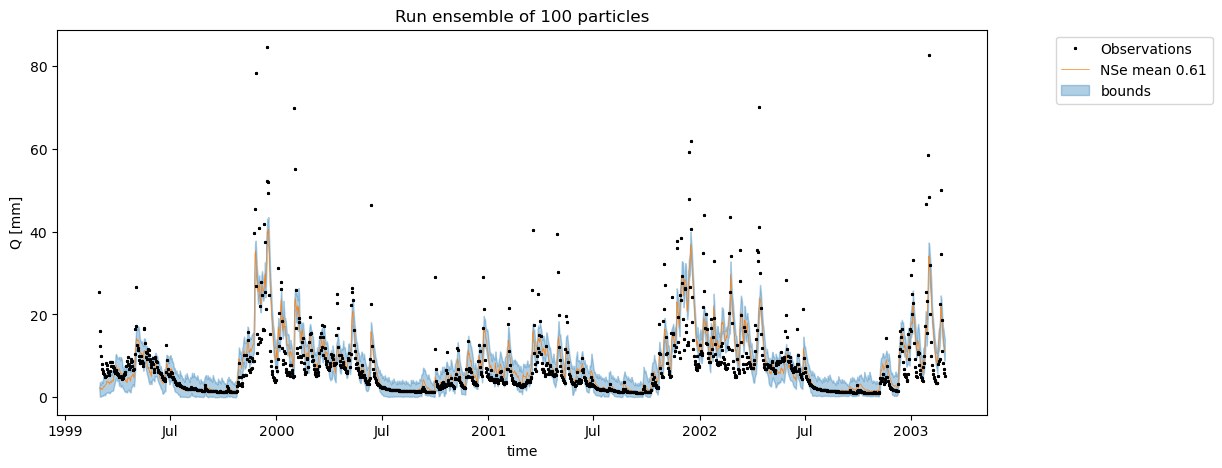

In [15]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"NSe mean {NSE_mean_ens:.2f}",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
# ax.set_ylim((0,10))
# ax.set_xlim((pd.Timestamp('1998-01-01'),pd.Timestamp('1998-08-01')))
# ax.set_xlim((pd.Timestamp('2004-08-01'),pd.Timestamp('2005-12-01')))
if save:
    current_time = str(datetime.now())[:-10].replace(":","_")
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

In [16]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

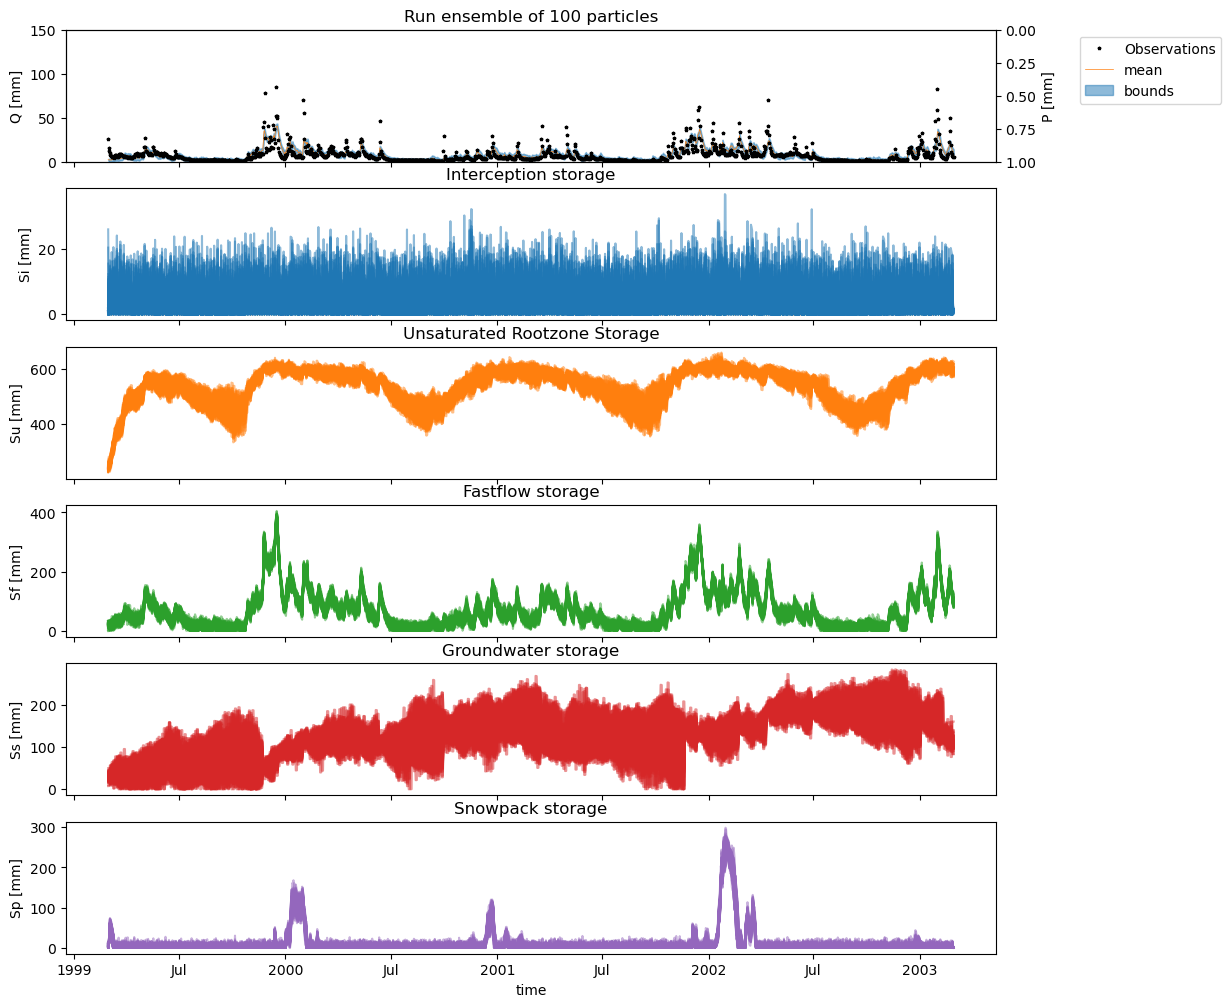

In [17]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
# ax_pr.bar(df_ensemble.index,ds['pr'].values[:len(time)],zorder=-10,label="Precipitation",color="grey")

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")

ax.set_title(f"Run ensemble of {n_particles} particles");

for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        ds_combined[stor_names[i]].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)
        axs[i+1].set_ylabel(f'{stor_names[i]} [{units[stor_names[i]]}]')

ax.set_ylim((0,150))
# remove all unncecearry xlabels
[ax.set_xlabel(None) for ax in axs[:-1]];
# [ax.set_ylabel("S [mm]") for ax in axs[1:]]
# if save:
#     fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)